In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
import scipy
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import json

In [2]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
from tensorflow.keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy

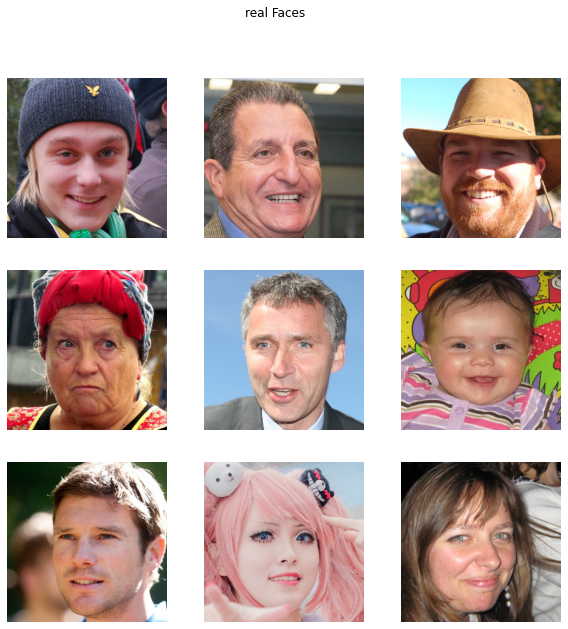

In [3]:
path = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

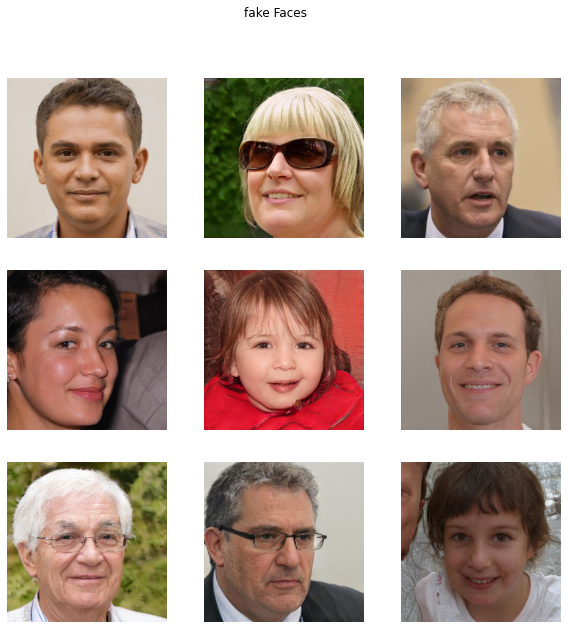

In [4]:
plot_img(path, 'fake').show()

In [5]:
bs = 64
row, col = 256, 256
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [6]:
from tensorflow.keras.applications import InceptionResNetV2
def get_model():
    densenet = InceptionResNetV2(weights='imagenet',
                           include_top=False,
                           input_shape=(256,256,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.2),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

spoofnet = get_model()
spoofnet.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization_203 (Bat (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 55,126,241
Trainable params: 55,064,673
N

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [8]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

hist = spoofnet.fit(training_set,
                    validation_data=validation_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=20
                   )

Epoch 1/20
1562/1562 [==============================] - 1446s 911ms/step - loss: 0.0998 - accuracy: 0.9627 - val_loss: 0.1017 - val_accuracy: 0.9627

Epoch 00001: val_loss improved from inf to 0.10170, saving model to spoffnet.h5
Epoch 2/20
1562/1562 [==============================] - 1255s 803ms/step - loss: 0.0273 - accuracy: 0.9900 - val_loss: 0.8409 - val_accuracy: 0.7723

Epoch 00002: val_loss did not improve from 0.10170
Epoch 3/20
1562/1562 [==============================] - 1253s 802ms/step - loss: 0.0217 - accuracy: 0.9924 - val_loss: 0.8905 - val_accuracy: 0.7791

Epoch 00003: val_loss did not improve from 0.10170
Epoch 4/20
1562/1562 [==============================] - 1252s 801ms/step - loss: 0.0169 - accuracy: 0.9941 - val_loss: 0.1484 - val_accuracy: 0.9732

Epoch 00004: val_loss did not improve from 0.10170

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
1562/1562 [==============================] - 1258s 805ms/step - loss: 0.00

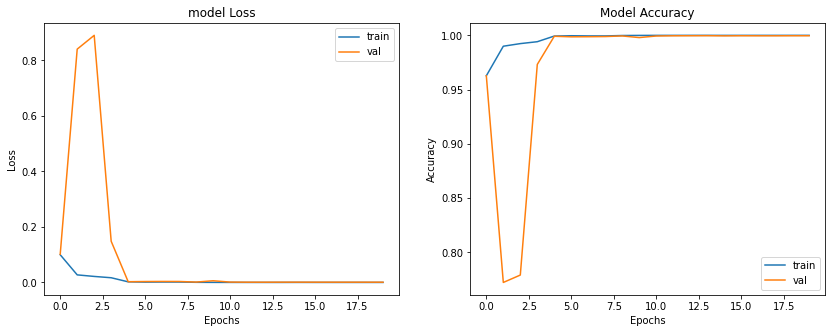

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [10]:
_, accu = spoofnet.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 226s 721ms/step - loss: 9.8775e-04 - accuracy: 0.9996
Final Test Acccuracy = 99.960


(1, 256, 256, 3)

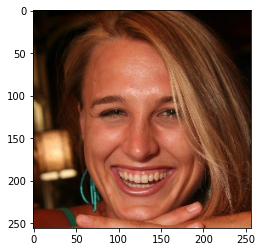

In [11]:
import PIL
from PIL import Image
im1 = Image.open('../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00001.jpg')
p1 = np.array(im1)
plt.imshow(p1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

The Prediction of the sample is: It Is ALL
Prediction Confidence Percentage is:  100.0


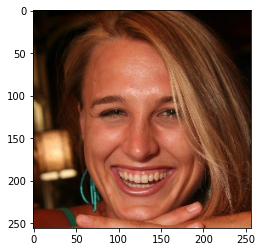

In [12]:
preds = spoofnet.predict(p1)
prediction = np.argmax(preds)
pct = np.max(preds)
if prediction == 0:
    print('The Prediction of the sample is: It Is ALL')
else:
    print('Prediction is Hem')
print("Prediction Confidence Percentage is: ", pct*100)
plt.imshow(im1);


/opt/conda/lib/python3.7/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


83


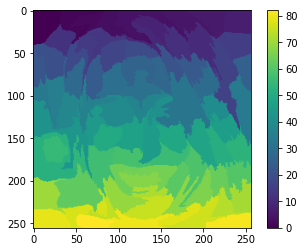

In [13]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
 
segmentation_fn = SegmentationAlgorithm(
    'slic',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=42
)

segments = segmentation_fn(im1)

print(len(np.unique(segments)))

plt.imshow(segments)
plt.colorbar();

In [14]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(im1), spoofnet.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

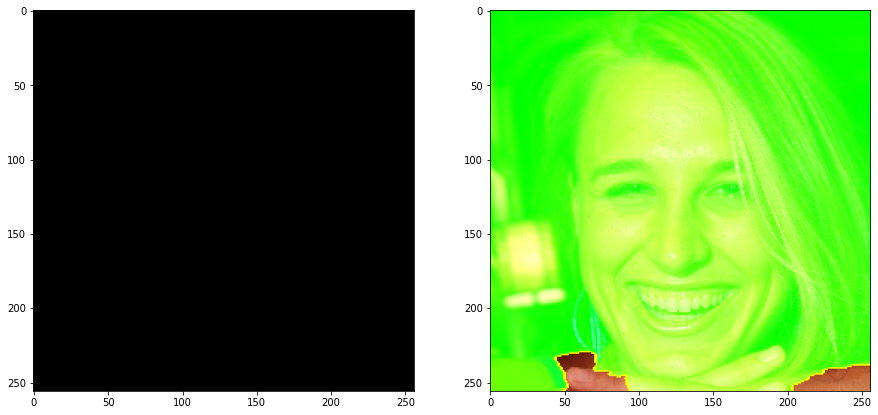

In [15]:
from skimage.segmentation import mark_boundaries


temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=40, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=40, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2));